In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint
from numba import njit

%matplotlib notebook

## Model

- First site has much higher affinity than second site
- Phosphorylation of first site brings kinase on to second site
- Kinase can fall off and bind to second site on its own (but affinity is low)
- Currently set to disallow multiple phosphates bound to single substrate - not sure what's most realistic

In [19]:
@njit(cache=True)
def dxdt(X, kf1, kr1, kcat1, kdephos1, kf2, kr2, kcat2, kdephos2):
    
    # Base species
    e = X[0]
    x__ = X[1]
    
    # Enzyme substrate complexes 
    xe_ = X[2]
    x_e = X[3]
    xee = X[4]
    
    # Phosphorylated substrate
    xp_ = X[5]
    x_p = X[6]
    xpp = X[7]
    
    # Mixed species
    xpe = X[8]
    xep = X[9]
    
    # Enzyme binding reactions
    bind = np.zeros(6)
    bind[0] = kf1 * e * x__
    bind[1] = kf1 * e * x_e * 0 # can't have enzyme bound twice
    bind[2] = kf1 * e * x_p
    bind[3] = kf2 * e * x__
    bind[4] = kf2 * e * xe_ * 0 # can't have enzyme bound twice
    bind[5] = kf2 * e * xp_
    
    # Enzyme unbinding reactions
    unbind = np.zeros(6)
    unbind[0] = kr1 * xe_
    unbind[1] = kr1 * xee
    unbind[2] = kr1 * xep
    unbind[3] = kr2 * x_e
    unbind[4] = kr2 * xee
    unbind[5] = kr2 * xpe

    # Forward catalytic reactions
    cat = np.zeros(6)
    cat[0] = kcat1 * xe_ * 0  # goes the processive route instead (skip[0])
    cat[1] = kcat1 * xee
    cat[2] = kcat1 * xep
    cat[3] = kcat2 * x_e
    cat[4] = kcat2 * xee
    cat[5] = kcat2 * xpe
    
    # Processive reactions
    skip = np.zeros(1)
    skip[0] = kcat1 * 1 * xe_
    
    # Dephosphorylation reactions
    dephos = np.zeros(6)
    dephos[0] = kdephos1 * xp_
    dephos[1] = kdephos1 * xpe
    dephos[2] = kdephos1 * xpp
    dephos[3] = kdephos2 * x_p
    dephos[4] = kdephos2 * xep
    dephos[5] = kdephos2 * xpp
    
    # Rate equations
    de = - bind[0] - bind[1] - bind[2] - bind[3] - bind[4] - bind[5] + unbind[0] + unbind[1] + unbind[2] + unbind[3] + unbind[4] + unbind[5] + cat[0] + cat[1] + cat[2] + cat[3] + cat[4] + cat[5]
    dx__ = - bind[0] - bind[3] + unbind[0] + unbind[3] + dephos[0] + dephos[3]
    dxe_ = - bind[4] - unbind[0] - cat[0] + bind[0] + unbind[4] + dephos[4] - skip[0]
    dx_e = - bind[1] - unbind[3] - cat[3] + bind[3] + unbind[1] + dephos[1]
    dxee = - unbind[1] - unbind[4] - cat[1] - cat[4] + bind[1] + bind[4]
    dxp_ = - bind[5] - dephos[0] + unbind[5] + cat[0] + dephos[5]
    dx_p = - bind[2] - dephos[3] + unbind[2] + cat[3] + dephos[2]
    dxpp = - dephos[2] - dephos[5] + cat[2] + cat[5]
    dxpe = - unbind[5] - cat[5] - dephos[1] + bind[5] + cat[1] + skip[0]
    dxep = - unbind[2] - cat[2] - dephos[4] + bind[2] + cat[4]
    
    return [de, dx__, dxe_, dx_e, dxee, dxp_, dx_p, dxpp, dxpe, dxep]

## Titrating PKC: WT vs S241A vs AxA

WT

<IPython.core.display.Javascript object>


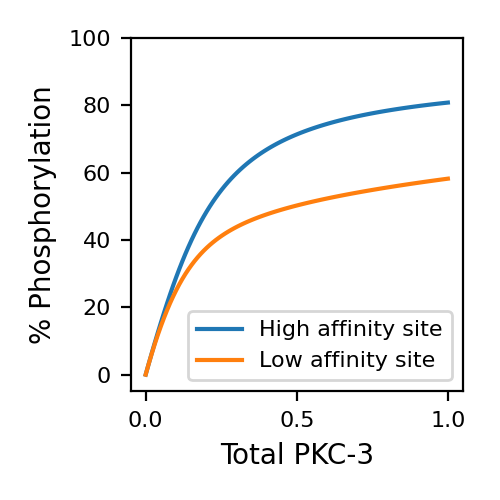

In [47]:
fig, ax = plt.subplots()
dosages = np.linspace(0, 1, 100)
res = np.zeros([100, 4])

for i, d in enumerate(dosages):
    def func(X, t=0):
        return dxdt(X, kf1=1, kr1=0.1, kcat1=1, kdephos1=0.1, kf2=0.1, kr2=0.1, kcat2=1, kdephos2=0.1)
    
    sol = odeint(func, [d, 1, 0, 0, 0, 0, 0, 0, 0, 0],  t=np.linspace(0, 100, 1000))[-1]
    
    x__ = sol[1] + sol[2] + sol[3] + sol[4]
    xp_ = sol[5] + sol[8]
    x_p = sol[6] + sol[9]
    xpp = sol[7]
    e = sol[0]
#     res[i, :] = [x__, xp_, x_p, xpp]
    res[i, :] = [x__, xp_ + xpp, x_p + xpp, xpp]

ax.plot(dosages, 100 * res[:, 1], label='High affinity site')
ax.plot(dosages, 100 * res[:, 2], label='Low affinity site')
ax.set_xlabel('Total PKC-3')
ax.set_ylabel('% Phosphorylation')
ax.set_ylim(-5, 100)
ax.tick_params(axis='both', labelsize=8)
ax.legend(fontsize=8)
fig.set_size_inches(2.5, 2.5)
fig.tight_layout()
# fig.savefig('Figs/wt.png', dpi=150)

S241A

<IPython.core.display.Javascript object>


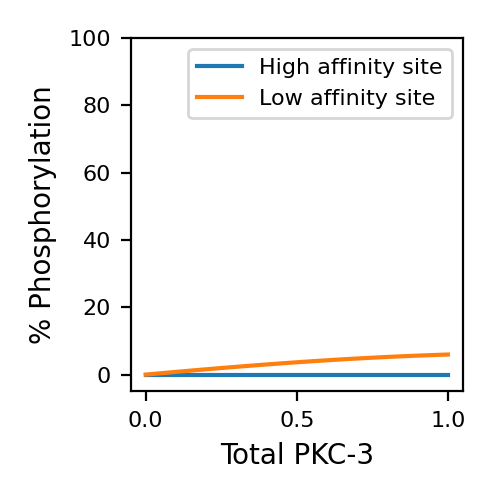

In [48]:
fig, ax = plt.subplots()
dosages = np.linspace(0, 1, 100)
res = np.zeros([100, 4])

for i, d in enumerate(dosages):
    def func(X, t=0):
        return dxdt(X, kf1=1, kr1=0.1, kcat1=0, kdephos1=0.1, kf2=0.1, kr2=0.1, kcat2=1, kdephos2=0.1)
    
    sol = odeint(func, [d, 1, 0, 0, 0, 0, 0, 0, 0, 0],  t=np.linspace(0, 100, 1000))[-1]
    
    x__ = sol[1] + sol[2] + sol[3] + sol[4]
    xp_ = sol[5] + sol[8]
    x_p = sol[6] + sol[9]
    xpp = sol[7]
    e = sol[0]
#     res[i, :] = [x__, xp_, x_p, xpp]
    res[i, :] = [x__, xp_ + xpp, x_p + xpp, xpp]

ax.plot(dosages, 100 * res[:, 1], label='High affinity site')
ax.plot(dosages, 100 * res[:, 2], label='Low affinity site')
ax.set_xlabel('Total PKC-3')
ax.set_ylabel('% Phosphorylation')
ax.set_ylim(-5, 100)
ax.tick_params(axis='both', labelsize=8)
ax.legend(fontsize=8)
fig.set_size_inches(2.5, 2.5)
fig.tight_layout()
# fig.savefig('Figs/s241a.png', dpi=150)

AxA

<IPython.core.display.Javascript object>


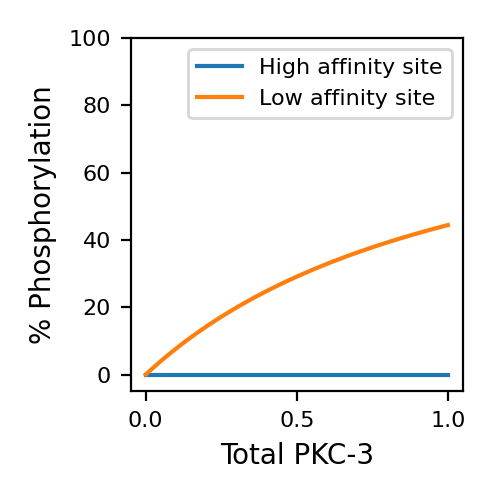

In [49]:
fig, ax = plt.subplots()
dosages = np.linspace(0, 1, 100)
res = np.zeros([100, 4])

for i, d in enumerate(dosages):
    def func(X, t=0):
        return dxdt(X, kf1=0, kr1=0.1, kcat1=0.1, kdephos1=0.1, kf2=0.1, kr2=0.1, kcat2=1, kdephos2=0.1)
    
    sol = odeint(func, [d, 1, 0, 0, 0, 0, 0, 0, 0, 0],  t=np.linspace(0, 100, 1000))[-1]
    
    x__ = sol[1] + sol[2] + sol[3] + sol[4]
    xp_ = sol[5] + sol[8]
    x_p = sol[6] + sol[9]
    xpp = sol[7]
    e = sol[0]
#     res[i, :] = [x__, xp_, x_p, xpp]
    res[i, :] = [x__, xp_ + xpp, x_p + xpp, xpp]

ax.plot(dosages, 100 * res[:, 1], label='High affinity site')
ax.plot(dosages, 100 * res[:, 2], label='Low affinity site')
ax.set_xlabel('Total PKC-3')
ax.set_ylabel('% Phosphorylation')
ax.set_ylim(-5, 100)
ax.tick_params(axis='both', labelsize=8)
ax.legend(fontsize=8)
fig.set_size_inches(2.5, 2.5)
fig.tight_layout()
# fig.savefig('Figs/axa.png', dpi=150)

AxA + S241A

<IPython.core.display.Javascript object>


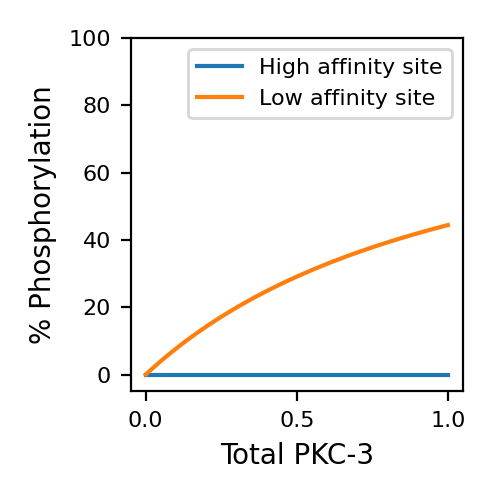

In [50]:
fig, ax = plt.subplots()
dosages = np.linspace(0, 1, 100)
res = np.zeros([100, 4])

for i, d in enumerate(dosages):
    def func(X, t=0):
        return dxdt(X, kf1=0, kr1=0.1, kcat1=0, kdephos1=0.1, kf2=0.1, kr2=0.1, kcat2=1, kdephos2=0.1)
    
    sol = odeint(func, [d, 1, 0, 0, 0, 0, 0, 0, 0, 0],  t=np.linspace(0, 100, 1000))[-1]
    
    x__ = sol[1] + sol[2] + sol[3] + sol[4]
    xp_ = sol[5] + sol[8]
    x_p = sol[6] + sol[9]
    xpp = sol[7]
    e = sol[0]
#     res[i, :] = [x__, xp_, x_p, xpp]
    res[i, :] = [x__, xp_ + xpp, x_p + xpp, xpp]

ax.plot(dosages, 100 * res[:, 1], label='High affinity site')
ax.plot(dosages, 100 * res[:, 2], label='Low affinity site')
ax.set_xlabel('Total PKC-3')
ax.set_ylabel('% Phosphorylation')
ax.set_ylim(-5, 100)
ax.tick_params(axis='both', labelsize=8)
ax.legend(fontsize=8)
fig.set_size_inches(2.5, 2.5)
fig.tight_layout()
# fig.savefig('Figs/axa_s241a.png', dpi=150)

## Titrating substrate level

WT

In [7]:
# fig, ax = plt.subplots()
# dosages = np.linspace(0, 2, 100)
# res = np.zeros([100, 4])

# for i, d in enumerate(dosages):
#     def func(X, t=0):
#         return dxdt(X, kf1=1, kr1=0.1, kcat1=1, kdephos1=0.1, kf2=0.1, kr2=0.1, kcat2=1, kdephos2=0.1)
    
#     sol = odeint(func, [0.1, d, 0, 0, 0, 0, 0, 0, 0, 0],  t=np.linspace(0, 100, 1000))[-1]
    
#     x__ = sol[1] + sol[2] + sol[3] + sol[4]
#     xp_ = sol[5] + sol[8]
#     x_p = sol[6] + sol[9]
#     xpp = sol[7]
#     e = sol[0]
# #     res[i, :] = [x__, xp_, x_p, xpp]
#     res[i, :] = [x__, (xp_ + xpp) / d, (x_p + xpp) / d, xpp / d]

# ax.plot(dosages, 100 * res[:, 1], label='High affinity site')
# ax.plot(dosages, 100 * res[:, 2], label='Low affinity site')
# ax.legend()
# ax.set_xlabel('Total PAR-2 (a.u.)')
# # ax.set_ylabel('% Phosphorylation')
# ax.set_ylim(-5, 100)
# fig.set_size_inches(3, 3)
# fig.tight_layout()
# # fig.savefig('Figs/wt.png', dpi=150)

S241A

In [8]:
# fig, ax = plt.subplots()
# dosages = np.linspace(0, 2, 100)
# res = np.zeros([100, 4])

# for i, d in enumerate(dosages):
#     def func(X, t=0):
#         return dxdt(X, kf1=1, kr1=0.1, kcat1=0, kdephos1=0.1, kf2=0.1, kr2=0.1, kcat2=1, kdephos2=0.1)
    
#     sol = odeint(func, [0.1, d, 0, 0, 0, 0, 0, 0, 0, 0],  t=np.linspace(0, 100, 1000))[-1]
    
#     x__ = sol[1] + sol[2] + sol[3] + sol[4]
#     xp_ = sol[5] + sol[8]
#     x_p = sol[6] + sol[9]
#     xpp = sol[7]
#     e = sol[0]
# #     res[i, :] = [x__, xp_, x_p, xpp]
#     res[i, :] = [x__, (xp_ + xpp) / d, (x_p + xpp) / d, xpp / d]

# ax.plot(dosages, 100 * res[:, 1], label='High affinity site')
# ax.plot(dosages, 100 * res[:, 2], label='Low affinity site')
# ax.legend()
# ax.set_xlabel('Total PAR-2 (a.u.)')
# # ax.set_ylabel('% Phosphorylation')
# ax.set_ylim(-5, 100)
# fig.set_size_inches(3, 3)
# fig.tight_layout()
# # fig.savefig('Figs/s241a.png', dpi=150)

AxA

In [9]:
# fig, ax = plt.subplots()
# dosages = np.linspace(0, 1, 100)
# res = np.zeros([100, 4])

# for i, d in enumerate(dosages):
#     def func(X, t=0):
#         return dxdt(X, kf1=0, kr1=0.1, kcat1=1, kdephos1=0.1, kf2=0.1, kr2=0.1, kcat2=1, kdephos2=0.1)
    
#     sol = odeint(func, [0.1, d, 0, 0, 0, 0, 0, 0, 0, 0],  t=np.linspace(0, 100, 1000))[-1]
    
#     x__ = sol[1] + sol[2] + sol[3] + sol[4]
#     xp_ = sol[5] + sol[8]
#     x_p = sol[6] + sol[9]
#     xpp = sol[7]
#     e = sol[0]
# #     res[i, :] = [x__, xp_, x_p, xpp]
#     res[i, :] = [x__, (xp_ + xpp) / d, (x_p + xpp) / d, xpp / d]

# ax.plot(dosages, 100 * res[:, 1], label='High affinity site')
# ax.plot(dosages, 100 * res[:, 2], label='Low affinity site')
# ax.legend()
# ax.set_xlabel('Total PAR-2 (a.u.)')
# # ax.set_ylabel('% Phosphorylation')
# ax.set_ylim(-5, 100)
# fig.set_size_inches(3, 3)
# fig.tight_layout()
# # fig.savefig('Figs/axa.png', dpi=150)

AxA + S241A

In [10]:
# fig, ax = plt.subplots()
# dosages = np.linspace(0, 1, 100)
# res = np.zeros([100, 4])

# for i, d in enumerate(dosages):
#     def func(X, t=0):
#         return dxdt(X, kf1=0, kr1=0.1, kcat1=0, kdephos1=0.1, kf2=0.1, kr2=0.1, kcat2=1, kdephos2=0.1)
    
#     sol = odeint(func, [0.1, d, 0, 0, 0, 0, 0, 0, 0, 0],  t=np.linspace(0, 100, 1000))[-1]
    
#     x__ = sol[1] + sol[2] + sol[3] + sol[4]
#     xp_ = sol[5] + sol[8]
#     x_p = sol[6] + sol[9]
#     xpp = sol[7]
#     e = sol[0]
# #     res[i, :] = [x__, xp_, x_p, xpp]
#     res[i, :] = [x__, (xp_ + xpp) / d, (x_p + xpp) / d, xpp / d]

# ax.plot(dosages, 100 * res[:, 1], label='High affinity site')
# ax.plot(dosages, 100 * res[:, 2], label='Low affinity site')
# ax.legend()
# ax.set_xlabel('Total PAR-2 (a.u.)')
# # ax.set_ylabel('% Phosphorylation')
# ax.set_ylim(-5, 100)
# fig.set_size_inches(3, 3)
# fig.tight_layout()
# # fig.savefig('Figs/axa_s241a.png', dpi=150)